In [91]:
import pandas as pd
import numpy as np
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import warnings
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")
import glob
import random
import sys
import networkx as nx
import matplotlib.pyplot as plt
# import folium
import osmnx as ox
import pandana as pdna
import libpysal as lps
import seaborn as sns
import mapclassify as mc
# import esda
from difflib import SequenceMatcher
from pathlib import Path
import statsmodels.api as sm
from scipy import stats
from statsmodels.graphics.api import abline_plot

import six
import uuid
import pickle
from sqlalchemy import create_engine

engine = create_engine('postgresql://postgres@localhost:5432/david')

from matplotlib import colors
from matplotlib.collections import LineCollection
from shapely.geometry import Point, Polygon
from utils import show_values
pd.set_option('display.max_columns', 500)

sys.path.append('/Users/david/Dropbox/PhD/Scripts/Spatial analyses')
# import pyspace

## Import FDGC's data

In [92]:
#Set working directory
mydir = Path(os.getcwd())
data_folder = mydir / '../Data' #Set data folder

In [93]:
file = data_folder / "extractionGE_v3.csv" #Data source file containing the screening data
df = pd.read_csv(file,sep = ";",low_memory = False) #Load data

In [94]:
len(df.numeroDossier.unique())

136529

In [95]:
df

,numeroDossier,numeroInvitation,GroupeAge,numeroDepistage,adresse1,adresse2,adresse3,localité,NPA,etatCivil,profession,medecin,autreMedecin,dateInvitation,dateRappel,dateMammographie,mammoAnterieure,ATF,conclusion,centre
0,1008774935,1,45-49,0,"24, ROUTE D'AVULLY",NaN,NaN,Avully,1237,Marié,NaN,non,non,1999-03-15,NaN,NaN,NaN,NaN,NaN,NaN
1,1008778175,1,45-49,0,"22, RUE JOSEPH-GIRARD",NaN,NaN,Carouge GE,1227,Célibataire,622 - PREPARATRICE EN PHARMACIE,non,non,1999-03-15,NaN,NaN,NaN,NaN,NaN,NaN
2,1008781955,1,45-49,0,"65, RUE DES LATTES",NaN,NaN,Meyrin,1217,Marié,NaN,non,non,1999-03-15,NaN,NaN,NaN,NaN,NaN,NaN
3,1008784926,1,45-49,0,"1, RUE JEAN-VIOLETTE",NaN,NaN,Genève,1205,Divorcé,NaN,non,non,1999-03-15,NaN,NaN,NaN,NaN,NaN,NaN
4,1008804096,1,60-64,0,C/O M. BRIFFOD NICOLAS,"100, ROUTE D'HERMANCE",NaN,Collonge-Bellerive,1245,Marié,951 - RETRAITEE,non,non,1999-03-15,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
596975,5008614140,2,65-69,0,AVENUE DES GRANDES-COMMUNES 62 BIS,NaN,NaN,Onex,1213,NaN,NaN,non,non,2021-02-22,NaN,NaN,NaN,NaN,NaN,NaN
596976,6008388438,5,55-59,3,ROUTE DE SACONNEX-D'ARVE 109,NaN,NaN,Plan-les-Ouates,1228,Divorcé,NaN,oui,non,2021-02-23,NaN,2021-04-01,oui,non,Négative,ImageRive
596977,1008381186,3,55-59,1,AVENUE DU VIEUX-BOURG 33,NaN,NaN,Chêne-Bourg,1225,Marié,903 - ENSEIGNANTE,oui,non,2021-02-24,NaN,2021-03-24,oui,oui,Négative,Clinique Générale Beaulieu
596978,7009083424,9,70-74,8,17 RUE JULES VERNE,NaN,NaN,ANNEMASSE - FRANCE,74100,NaN,NaN,oui,non,2021-02-24,2021-02-24,2021-02-24,oui,non,Négative,Clinique des Grangettes


## Import administrative gdfs

In [5]:
lake = gpd.read_file('/Users/david/Dropbox/PhD/GitHub/COVID19/Data/Mapping/lake.geojson')
cantons = gpd.read_file(
    '/Users/david/Dropbox/PhD/Data/Databases/SITG/SHAPEFILE_LV95_LN02/swissBOUNDARIES3D_1_3_TLM_KANTONSGEBIET.shp')
communes = gpd.read_file(
    '/Users/david/Dropbox/PhD/Data/Databases/SITG/SHAPEFILE_LV95_LN02/swissBOUNDARIES3D_1_3_TLM_HOHEITSGEBIET.shp')
communes = communes[communes.KANTONSNUM == 25]
cantons = cantons.to_crs(2056)
communes = communes.to_crs(2056)

## Feature engineering

In [6]:
df['dateInvitation'] = pd.to_datetime(df['dateInvitation'])
df['dateMammographie'] = pd.to_datetime(df['dateMammographie'])

df['year_invit'] = df.dateInvitation.dt.year
df['year_mammo'] = df.dateMammographie.dt.year

In [7]:
df = df.assign(mammo = 1* (df.dateMammographie.isnull()==False))

## Pre-geocoding address cleaning

In [8]:
#Set all column names to lowercase
df.columns = map(str.lower, df.columns)

#eliminate noisy information from addresses
df.loc[df.adresse1.str.contains('C/O')==True, 'adresse1'] = '' 
df.loc[df.adresse1.str.contains('CASE POSTALE')==True, 'adresse1'] = ''
df.loc[df.adresse2.str.contains('CASE POSTALE')==True, 'adresse2'] = ''
df.loc[df.adresse2.isnull()==True, 'adresse2'] = ''

#Create new column containing country information
df['country'] = 'Suisse'
df.loc[df.npa.str.contains('F-|FR-')==True, 'country'] = 'France'
df.loc[df.localité.str.contains('FRANCE')==True, 'country'] = 'France'

# df['city'] = df['city'].astype(str)
# df.loc[df.city == 'Athenaz (Avusy)','city'] = 'Avusy'
# df.loc[df.city == 'Chambésy','city'] ='Pregny-Chambésy'
# df.loc[df.city.str.contains('Lancy'),'city'] = 'Lancy'
# df.loc[df.city == 'Collex','city'] = 'Collex-Bossy'
# df.loc[df.city == 'La Croix-de-Rozon','city'] = 'Bardonnex'
# df.loc[df.city == 'Perly','city'] = 'Perly-Certoux'
# df.loc[df.city.str.contains('Meyrin'),'city'] = 'Meyrin'
# df.loc[df.city.str.contains('Grand-Lancy'),'city'] = 'Grand-Lancy'
# df.loc[df.city.str.contains('Petit-Lancy'),'city'] = 'Petit-Lancy'
#Repare npa field
df['npa'] = df['npa'].str.replace('F-','').str.replace('FR -','').str.replace('F -','').str.replace('F','').str.replace('-','').str.strip().replace('',np.nan)
df['npa'] = df.npa.fillna(-1).astype(float).astype(int)
df['npa'] = df['npa'].astype(str).replace('-1',np.nan)

#Create new column : street
df['street'] = df['adresse1'] +' '+ df['adresse2']
df['street'] = df['street'].replace(',','', regex = True)

df = df.rename(columns = {'npa':'zipcode','localité':'city'})
df['canton'] = 'ge'
df.to_feather(data_folder/'first_cleanup_giracs.feather')

_regbl_data_folder = Path("/Users/david/Dropbox/PhD/GitHub/Swiss-Geocoder/").resolve()
regbl_address = pd.read_feather(_regbl_data_folder / 'Data' /'Clean_data'/ 'regbl_address_2022.feather')
regbl_street = pd.read_feather(_regbl_data_folder / 'Data' /'Clean_data'/ 'regbl_street_2022.feather')

In [9]:
df.shape

(596980, 26)

## Post-geocoding 

Geocoding using in-house procedure based on string-matching against a CH Federal database on all existing addresses in the country.

In [10]:
### Geocoded dataset
df_geocoded = pd.read_excel(data_folder/'Processed data'/'giracs_geocoded_80.xlsx')
df_geocoded = df_geocoded.drop(['Unnamed: 0'], axis = 1)

In [11]:
#Transform variable to binary
df_geocoded.loc[df_geocoded.medecin == 'oui','medecin_code'] =1
df_geocoded.loc[df_geocoded.medecin == 'non','medecin_code'] =0
df_geocoded.loc[df_geocoded.medecin == 'je ne sais pas','medecin_code'] = np.nan

In [12]:
#Transform variable to binary
df_geocoded.loc[df_geocoded.autremedecin == 'oui','autremedecin_code'] =1
df_geocoded.loc[df_geocoded.autremedecin == 'non','autremedecin_code'] =0
df_geocoded.loc[df_geocoded.autremedecin == 'je ne sais pas','autremedecin_code'] = np.nan

In [13]:
#Transform variable to binary
df_geocoded.loc[df_geocoded.mammoanterieure == 'oui','mammoanterieure_code'] =1
df_geocoded.loc[df_geocoded.mammoanterieure == 'non','mammoanterieure_code'] =0
df_geocoded.loc[df_geocoded.mammoanterieure == 'je ne sais pas','mammoanterieure_code'] = np.nan

In [14]:
#Transform variable to binary
df_geocoded.loc[df_geocoded.atf == 'oui','atf_code'] =1
df_geocoded.loc[df_geocoded.atf == 'non','atf_code'] =0
df_geocoded.loc[df_geocoded.atf == 'je ne sais pas','atf_code'] = np.nan

In [15]:
#Transform variable to binary
rappel = 1* (df_geocoded.daterappel.isnull()==False)
df_geocoded = df_geocoded.assign(rappel = rappel)

In [16]:
#Transform variable to binary
df_geocoded = df_geocoded.assign(mammo = 1* (df_geocoded.datemammographie.isnull()==False))

In [17]:
#Create variables from date columns
df_geocoded['dateinvitation'] = pd.to_datetime(df_geocoded['dateinvitation'])
df_geocoded['daterappel'] = pd.to_datetime(df_geocoded['daterappel'])
df_geocoded['datemammographie'] = pd.to_datetime(df_geocoded['datemammographie'])

In [18]:
#Create variables from date columns
df_geocoded['t_invit_rappel'] = df_geocoded['daterappel'] - df_geocoded['dateinvitation']
df_geocoded['t_invit_rappel']= df_geocoded['t_invit_rappel']/np.timedelta64(1,'D')

df_geocoded['t_invit_mammo'] = df_geocoded['datemammographie'] - df_geocoded['dateinvitation']
df_geocoded['t_invit_mammo']= df_geocoded['t_invit_mammo']/np.timedelta64(1,'D')

In [19]:
#Create variables from date columns
df_geocoded['year_invit'] = df_geocoded.dateinvitation.dt.year
df_geocoded['month_invit'] = df_geocoded.dateinvitation.dt.month
df_geocoded['day_invit'] = df_geocoded.dateinvitation.dt.day
df_geocoded['weekday_invit'] = df_geocoded.dateinvitation.dt.day_name()

df_geocoded['year_rappel'] = df_geocoded.daterappel.dt.year
df_geocoded['month_rappel'] = df_geocoded.daterappel.dt.month
df_geocoded['day_rappel'] = df_geocoded.daterappel.dt.day
df_geocoded['weekday_rappel'] = df_geocoded.daterappel.dt.day_name()

df_geocoded['year_mammo'] = df_geocoded.datemammographie.dt.year
df_geocoded['month_mammo'] = df_geocoded.datemammographie.dt.month
df_geocoded['day_mammo'] = df_geocoded.datemammographie.dt.day
df_geocoded['weekday_mammo'] = df_geocoded.datemammographie.dt.day_name()

In [20]:
#Return a sequence that corresponds to the actual numeroinvitation ...without the weird things we find in the original column
df_geocoded['dt_invit'] = pd.to_datetime([f'{y}-{m}-{d}' for y, m, d in zip(df_geocoded.year_invit, df_geocoded.month_invit, df_geocoded.day_invit)])
df_geocoded = df_geocoded.sort_values(['numerodossier','dt_invit'])
df_geocoded['numeroinvitation_seq'] = df_geocoded.groupby('numerodossier').cumcount()+1

In [21]:
n_invit = df_geocoded.groupby('numerodossier').numeroinvitation_seq.nunique()
df_geocoded = df_geocoded.join(n_invit, on='numerodossier', rsuffix='_n')

#### Participation changes between any two invitation (to the same woman)

In [22]:
df_geocoded['mammo_last_invite'] = df_geocoded[['numerodossier','mammo']].groupby('numerodossier').diff()['mammo']

In [23]:
participation_chg = pd.DataFrame(df_geocoded[['numerodossier','mammo_last_invite']].groupby(['mammo_last_invite']).numerodossier.count()).reset_index()
participation_chg.columns = ['Participation change','n']
participation_chg['%'] = participation_chg['n'].mul(100)/participation_chg['n'].sum(axis = 0)
participation_chg['%'] = participation_chg['%'].round(2)

In [24]:
participation_change = df_geocoded[['numerodossier','mammo_last_invite']].dropna().groupby(['numerodossier']).mammo_last_invite.nunique().reset_index()
participation_change.columns = ['numerodossier','participation_change']
participation_change['participation_change'] = participation_change['participation_change']-1
df_geocoded = df_geocoded.merge(participation_change, on='numerodossier',how = 'left')

#### Time intervals between any two invitation (to the same woman)

In [25]:
%%time
df_geocoded['diff_years'] = df_geocoded[['numerodossier','dt_invit']].groupby('numerodossier').diff()['dt_invit']/np.timedelta64(1,'Y')

CPU times: user 18.6 ms, sys: 7.03 ms, total: 25.6 ms
Wall time: 24.8 ms


In [69]:
df_geocoded.shape

(581325, 60)

### Discard 2021 invitations

In [27]:
df_geocoded = df_geocoded[df_geocoded.year_invit != 2021]
print('Number of invitations :', df_geocoded.shape[0])
print('Number of women :', df_geocoded.numerodossier.nunique())

Number of invitations : 590117
Number of women : 135772


### Discard duplicates

In [28]:
clean_dupli =df_geocoded[(df_geocoded.duplicated(subset=['numerodossier','numeroinvitation'],keep=False))].sort_values(['numerodossier','month_invit','day_invit','mammo','groupeage']).drop_duplicates(subset = ['numerodossier','numeroinvitation'],keep = 'first')

df_geocoded['_dummy'] = df_geocoded['numerodossier'].astype(str) + df_geocoded['numeroinvitation'].astype(str)
clean_dupli['_dummy'] = clean_dupli['numerodossier'].astype(str) + clean_dupli['numeroinvitation'].astype(str)

df_geocoded = df_geocoded[(df_geocoded._dummy.isin(clean_dupli._dummy))==False]

df_geocoded = pd.concat([df_geocoded,clean_dupli])

print('Number of invitations :', df_geocoded.shape[0])
print('Number of women :', df_geocoded.numerodossier.nunique())

Number of invitations : 589879
Number of women : 135772


In [29]:
579033/589879

0.9816131782958878

### Discard out of age range invitations

In [30]:
df_geocoded.groupeage = df_geocoded.groupeage.astype('category')
df_geocoded['groupeage_cat'] = df_geocoded.groupeage.cat.codes

In [31]:
#Get age categories that are out of the age range guidelines for breast cancer screening
age_cats = df_geocoded.groupby('groupeage').size()
age_cats1000 = age_cats[age_cats > 1000]
age_cats =  pd.DataFrame(age_cats).reset_index()
age_cats.columns = ["Age group","Invitation count (n)"]

In [32]:
df_geocoded = df_geocoded[(df_geocoded.groupeage.isin(['50-54','55-59','60-64','65-69','70-74']))]

In [33]:
print('Number of invitations :', df_geocoded.shape[0])
print('Number of women :', df_geocoded.numerodossier.nunique())

Number of invitations : 585522
Number of women : 135664


In [34]:
589879 - 585522

4357

In [35]:
# Exclude 70-74 invited before 2013 since it wasn't rolled out yet
df_geocoded = df_geocoded[~((df_geocoded['year_invit'] < 2013) & (df_geocoded['groupeage'] == '70-74'))]

In [36]:
print('Number of invitations :', df_geocoded.shape[0])
print('Number of women :', df_geocoded.numerodossier.nunique())

Number of invitations : 581325
Number of women : 135203


In [37]:
585522- 581325

4197

In [38]:
#Create geodataframe
gdf_geocoded = gpd.GeoDataFrame(df_geocoded,crs = 2056,geometry = gpd.points_from_xy(df_geocoded['E'],df_geocoded['N']))
# Create geodataframe of unique addresses
gdf_geom_uniq = gdf_geocoded.drop_duplicates(subset = ['address_id','full_address'])
# Create geodataframe of all rows having a valid geocoding
gdf_geocoded_ok = gdf_geocoded[gdf_geocoded.comment.str.contains('Ok')]

In [39]:
#Print the number of different geometries after small alteration to addresses
gdf_geocoded.groupby('comment').size()

comment
Low quality                     1575
Low quality - Street level       199
No match                          62
Not in CH                        305
Ok                            578791
Ok - Street level                393
dtype: int64

In [40]:
gdf_geocoded[~gdf_geocoded.comment.str.contains('Ok')].shape[0]

2141

In [41]:
gdf_geocoded[gdf_geocoded.comment.str.contains('Ok')].shape[0]

579184

In [42]:
print('Number of invitations :', gdf_geocoded_ok.shape[0])
print('Number of women :', gdf_geocoded_ok.numerodossier.nunique())

Number of invitations : 579184
Number of women : 134845


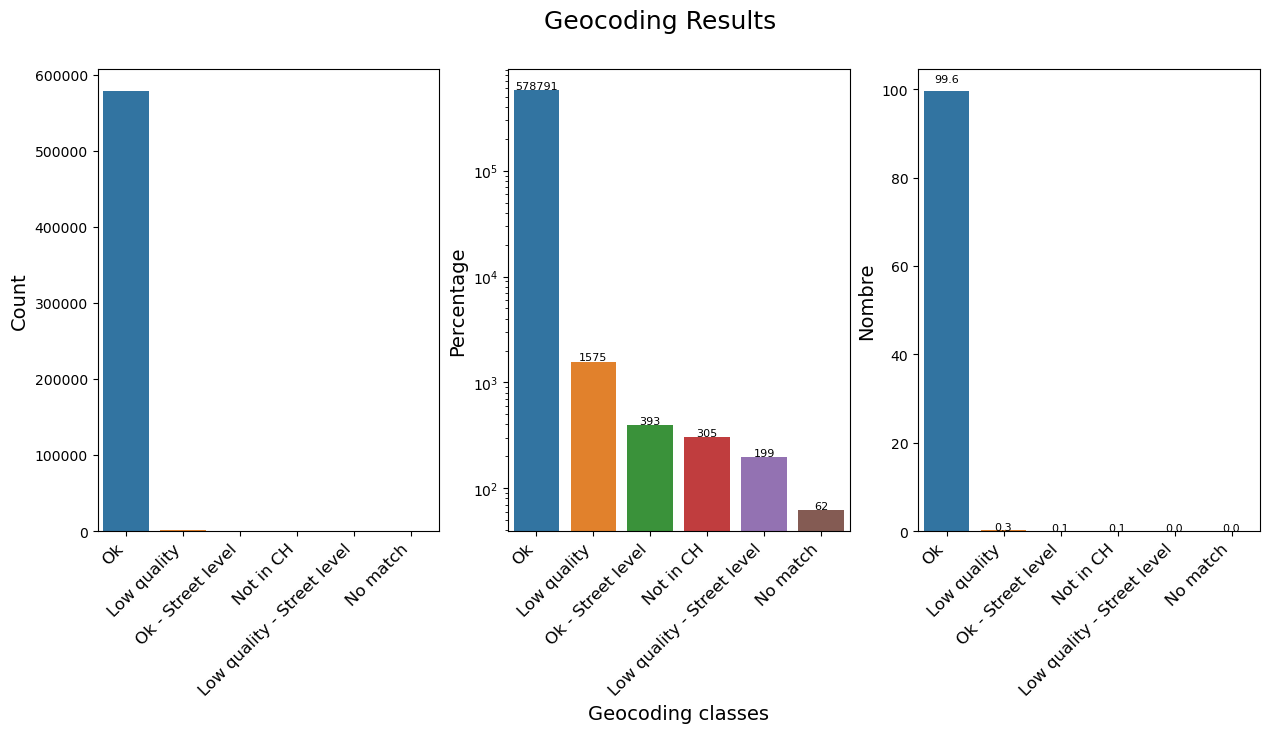

In [43]:
# sns.set_theme(style="white")
# sns.set_context("paper")

fig, axes = plt.subplots(1,3, figsize=(15, 6), sharey=False, sharex=True)
fig.suptitle('Geocoding Results', size = 18)
geocoding_res = pd.DataFrame(df_geocoded.comment.value_counts()).reset_index()
geocoding_res['count'] = geocoding_res['count'].astype(int)
chart = sns.barplot(x="comment", y="count", data=geocoding_res, ax = axes[0])
chart.set_xticklabels(chart.get_xticklabels(),size = 12, rotation=45, horizontalalignment='right')
chart.set_xlabel('',size = 14)
chart.set_ylabel('Count',size = 14)
# fig, axes = plt.subplots(figsize=(8, 8), sharey=False)
chart = sns.barplot(x="comment", y="count", data=geocoding_res, ax = axes[1])
chart.set_yscale("log")
chart.set_xticklabels(chart.get_xticklabels(),size = 12, rotation=45, horizontalalignment='right')
chart.set_xlabel('Geocoding classes',size = 14)
chart.set_ylabel('Percentage',size = 14)
show_values(chart, digits = 0)
# fig, axes = plt.subplots(figsize=(8, 8), sharey=False)

geocoding_res = pd.DataFrame(df_geocoded.comment.value_counts(normalize = True).mul(100)).reset_index()
chart = sns.barplot(x="comment", y="proportion", data=geocoding_res, ax = axes[2])
chart.set_xticklabels(chart.get_xticklabels(),size = 12, rotation=45, horizontalalignment='right')
chart.set_xlabel('',size = 14)
chart.set_ylabel('Nombre',size = 14)
show_values(chart, digits = 1)

## Accessibility analyses

### Screening centers

In [44]:
# Collect addresses from the centers
dic_centre = {'HUG - Maternité':[46.191174, 6.146240],
              'ImageRive':[46.202599, 6.150099],
              'CIO':[46.185712, 6.105039],
              'Clinique des Grangettes':[46.199840, 6.181743],
              'Clinique Générale Beaulieu':[46.188670, 6.161817],
              'MédImage SA':[46.196916, 6.154018],
              "Centre d'Imagerie Rive Gauche CIRG":[46.240752, 6.199488],
              'Hôpital de la Tour':[46.228690, 6.066374],
              "Institut d'Imagerie Médicale SA":[46.194231, 6.144169],
              "Centre d'Imagerie de la Servette":[46.212972, 6.125423],
              'Affidea CDRC':[46.186589, 6.143063],
              "Centre d'imagerie Rive Droite SA":[46.208147, 6.143412],
              'Imagerie Médicale Battikha':[46.210023, 6.143956],
              'Cabinet de radiologie Drs Berger & Teicher':[46.213017, 6.131947],
              'Imagerive LAC':[46.216705, 6.148251],
              'Cabinet de radiologie Dr Guinand-Mkinsi':[46.195798, 6.154703],
              'Clinique de la Colline':[46.191812, 6.149944],
              'Cabinet de radiologie Dr Arroja':[46.199595, 6.155487],
              'Centre Imagerie Versoix':[46.28096883497587, 6.165184209801708],
             "CIMG centre Imagerie médicale Genève":[46.216800901902246, 6.148267060384218]}

In [45]:
df_centre =  pd.DataFrame.from_dict(dic_centre).T.reset_index()
df_centre.columns = ['center_name','lat','lon']

In [46]:
df_centre.loc[df_centre['center_name'].isin(["Cabinet de radiologie Dr Guinand-Mkinsi",
"Cabinet de radiologie Drs Berger & Teicher",
"Affidea CDRC",
"Clinique des Grangettes",
"Clinique Générale Beaulieu",
"Hôpital de la Tour",
"HUG - Maternité",
"Imagerie Médicale Battikha",
"ImageRive",
"Institut d'Imagerie Médicale SA",
"Rive Droite SA - Centre d'imagerie SA",
"Centre d'imagerie Rive Droite SA",
"Clinique de la Colline",                                    
"Cabinet de radiologie Dr Arroja"]),'year_start'] = 1999
df_centre.loc[df_centre['center_name'].isin(['MédImage SA']),'year_start'] = 2010
df_centre.loc[df_centre['center_name'].isin(['CIO']),'year_start'] = 2012
df_centre.loc[df_centre['center_name'].isin(["Centre d'Imagerie Rive Gauche CIRG"]),'year_start'] = 2013
df_centre.loc[df_centre['center_name'].isin(["Centre d'Imagerie de la Servette"]),'year_start'] = 2016
df_centre.loc[df_centre['center_name'].isin(["CIMG centre Imagerie médicale Genève"]),'year_start'] = 2016
df_centre.loc[df_centre['center_name'].isin(["Imagerive LAC"]),'year_start'] = 2019
df_centre.loc[df_centre['center_name'].isin(["Centre Imagerie Versoix"]),'year_start'] = 2020
df_centre.loc[df_centre['center_name'].isin(['Cabinet de radiologie Drs Berger & Teicher']),'year_end'] = 2016
df_centre.loc[df_centre['center_name'].isin(['Cabinet de radiologie Dr Guinand-Mkinsi']),'year_end'] = 2013

In [47]:
# gdf_centre = pyspace.make_gdf(df_centre,4326,'lat','lon')
gdf_centre = gpd.GeoDataFrame(df_centre, crs= 4326, geometry = gpd.points_from_xy(df_centre['lon'],df_centre['lat']))
gdf_centre.to_file(data_folder/'BC_ScreeningCenters.geojson',driver = 'GeoJSON')

In [48]:
gdf_centre.index = gdf_centre.index.map(int)
gdf_centre['lon'] = gdf_centre.geometry.x
gdf_centre['lat'] = gdf_centre.geometry.y
gdf_centre['id'] = gdf_centre.index+1000000
gdf_centre['quantity'] = 1.0
gdf_centre['category'] = 'centre'
gdf_centre = gdf_centre.reset_index(drop=True)

In [49]:
gdf_centre = gpd.GeoDataFrame(gdf_centre, crs= 4326, geometry = gpd.points_from_xy(gdf_centre['lon'],gdf_centre['lat']))

### Import road network

In [50]:
# If network not previously saved
# G = ox.graph_from_place('Canton de Genève, Switzerland', network_type='all', simplify= True, clean_periphery = True)
# Otherwise
with open(data_folder/'G.gpickle', 'rb') as f:
    G = pickle.load(f)

In [51]:
# Project networks
Gp_4326 = ox.project_graph(G, to_crs = 4326)
Gp_2056 = ox.project_graph(G, to_crs = 2056)

### Calculation of access measures

In [52]:
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)
gdf_edges = gdf_edges.reset_index()

<Axes: >

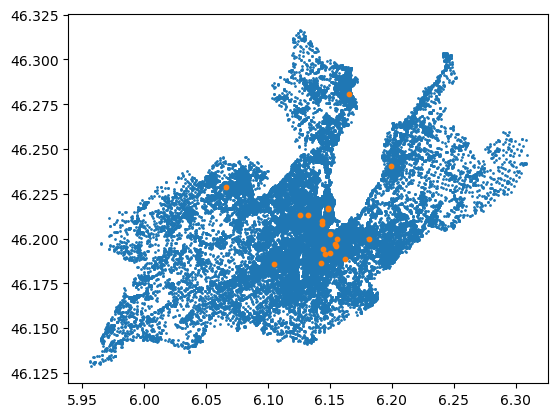

In [53]:
ax = gdf_nodes.plot(markersize = 1)
gdf_centre.plot(markersize = 10, ax = ax)

In [54]:
# Get nearest 2 POIs (screening center) at max 5km
net=pdna.Network(gdf_nodes["x"], gdf_nodes["y"], gdf_edges["u"], gdf_edges["v"],
                 gdf_edges[["length"]])
net.precompute(5000)
net.set_pois(category='centre', maxdist = 5000, maxitems=len(gdf_centre), x_col=gdf_centre['lon'], y_col=gdf_centre['lat'])
nearest_2 = net.nearest_pois(5000, "centre", num_pois=2)

Generating contraction hierarchies with 10 threads.
Setting CH node vector of size 58196
Setting CH edge vector of size 150081
Range graph removed 138926 edges of 300162
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


In [55]:
# Get POI density (screening centers) within 5km

x, y = gdf_centre.lon, gdf_centre.lat

gdf_centre["node_ids"] = net.get_node_ids(x, y)
net.set(gdf_centre["node_ids"], variable=gdf_centre['quantity'], name="centre")
density5000 = net.aggregate(5000, type="sum", decay="linear", name="centre")

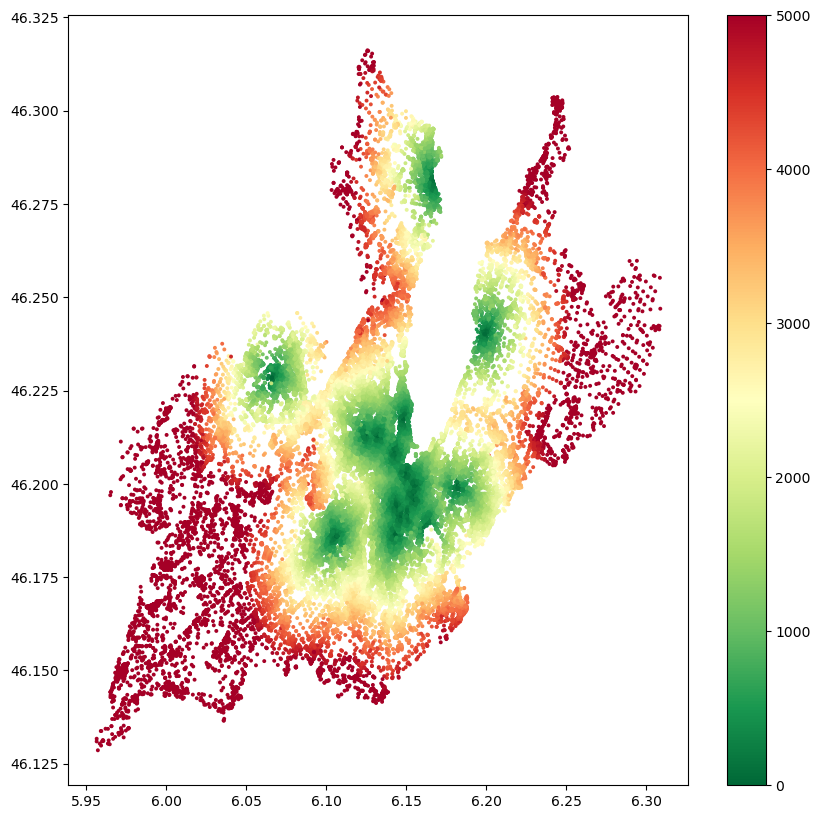

(<Figure size 1000x1000 with 2 Axes>, <Axes: >)

In [56]:
net.plot(nearest_2[1],
         fig_kwargs={'figsize': [10, 10]},
         plot_kwargs={'cmap': 'RdYlGn_r', 's': 8, 'edgecolor': 'none'})

In [57]:
nn_xy = ox.distance.nearest_nodes(Gp_2056, gdf_geocoded_ok.geometry.x, gdf_geocoded_ok.geometry.y)

In [58]:
gdf_geocoded_ok['nearest_node'] = nn_xy
gdf_geocoded_ok['center_nearest'] = gdf_geocoded_ok['nearest_node'].map(nearest_2[1].to_dict())

/Users/david/miniforge3/envs/giracs/lib/python3.10/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/david/miniforge3/envs/giracs/lib/python3.10/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [59]:
gdf_geocoded_ok['center_density'] = gdf_geocoded_ok['nearest_node'].map(density5000.to_dict())

/Users/david/miniforge3/envs/giracs/lib/python3.10/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [60]:
gdf_geocoded_ok_waccess = gdf_geocoded_ok.copy()

In [61]:
gdf_geocoded_ok_waccess = gpd.sjoin(gdf_geocoded_ok_waccess, cantons[cantons.NAME == 'Genève'][['geometry']], predicate = 'intersects')
gdf_geocoded_ok_waccess = gdf_geocoded_ok_waccess.drop('index_right', axis = 1)

In [62]:
print('Number of invitations :', gdf_geocoded_ok_waccess.shape[0])
print('Number of women :', gdf_geocoded_ok_waccess.numerodossier.nunique())

Number of invitations : 579033
Number of women : 134814


In [63]:
579184-579033

151

<Axes: >

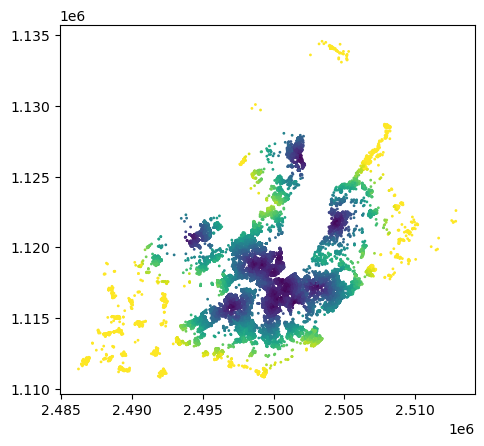

In [64]:
gdf_geocoded_ok_waccess[gdf_geocoded_ok_waccess.year_invit == 2019].plot('center_nearest', markersize = 1)

## SES Deprivation index

In [65]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## Deprivation index

query = """select nbid,"LOCALITY" locality,ciqmd,ptot,pm,pf,p0004,p0509,p1014,p1519,p2024,p2529,p3034,p3539,p4044,p4549,p5054,p5559,p6064,p6569,p7074,p7579,p8084,p8589,p90m,rpmssin,rpmsmar,rpmswid,rpmsdiv,rad3prim, rad3sec,rad3tert,rprprot,rprcath,rprochr,rprjew,rprmusl,rproth,rprnorel,rpnch,
rpnoce,
rpncam,
rpncas,
rpnceu,rpneeu,rpneceu,rpnfe,rpnme,rpnnaf,rpnnam,rpnneu,rpnnweu,rpnsam,rpnsas,rpnseas,rpnseeu,rpnsweu,rpnsubaf,rpnweu
,rphhpriv,rhhcoll,rhhp1p,rhhp2p,rhhp3p,rhhp4p,rhhp5p,rhhp6mp,rpfnone,rpfobl,rpfgen,rpfprof,rpfmat,rpfprsf,rpfprss ,rpfbac,rpfmas,rpfphd,rad,radf,radune,rado,radunef,radslib,dmdrent,b.geom geometry from data_raw.microgis_data_gva a, data_raw.microgis_geo_gva b where a.nbid = b."NBID" and b.geom is not null ;"""
microgis_data = gpd.GeoDataFrame.from_postgis(query,con = engine,geom_col = 'geometry')
# microgis_data = microgis_data.dropna()
microgis_data.crs = 'epsg:2056'



microgis_data['tertiary_education'] = microgis_data[['rpfbac','rpfmas','rpfphd']].sum(axis = 1)
microgis_data['rpforeign'] = 100 - microgis_data['rpnch']
microgis_data['wo_tertiary_education'] = 100-microgis_data['tertiary_education']
microgis_data['inv_ciqmd'] = -microgis_data['ciqmd']
microgis_data['inv_dmdrent'] = -microgis_data['dmdrent']
microgis_data['rad3primsec'] = 100 - microgis_data['rad3tert']
microgis_data['rp65+'] = (microgis_data.p6569+microgis_data.p7074+microgis_data.p7579+microgis_data.p8084+microgis_data.p8589+microgis_data.p90m)/microgis_data.ptot
microgis_data['rpdens'] = (microgis_data.ptot / microgis_data.geometry.area)*1000000
microgis_data['rphh3p-'] = microgis_data[['rhhp1p','rhhp2p','rhhp3p']].sum(axis = 1)
microgis_data['rphh3p+'] = 100 - microgis_data[['rhhp1p','rhhp2p','rhhp3p']].sum(axis = 1)
#Filter out any neighborhood having ptot = 0
microgis_data = microgis_data[microgis_data.ptot>0]

#Standardize selected variables
x = microgis_data[['rpforeign','inv_ciqmd','radune','wo_tertiary_education','inv_dmdrent','rad3primsec']].values
x = StandardScaler().fit_transform(x)

microgis_data.to_feather('./microgis_data_depriv.feather',index = False)

#PCA with 3 components
pca_depriv = PCA(n_components=3)
principalComponents_depriv = pca_depriv.fit_transform(x)

principal_depriv_Df = pd.DataFrame(data = principalComponents_depriv
             , columns = ['principal component 1', 'principal component 2','principal component 3'])

print('Explained variation per principal component: {}'.format(pca_depriv.explained_variance_ratio_))


microgis_data['deprivation_pca'] = -principalComponents_depriv.T[0]

# Fit your data on the scaler object
scaler = preprocessing.StandardScaler()
microgis_data[['deprivation_pca']] = scaler.fit_transform(microgis_data[['deprivation_pca']])
microgis_data['deprivation_pca'] = -principalComponents_depriv.T[0]
microgis_data['deprivation_pca_q5'] = pd.qcut(microgis_data['deprivation_pca'],5, labels = False)

pd.DataFrame(pca_depriv.components_,columns=microgis_data[['rpforeign','inv_ciqmd','radune','wo_tertiary_education','inv_dmdrent','rad3primsec']].columns,index = ['PC-1','PC-2','PC-3'])

Explained variation per principal component: [0.30674127 0.22933389 0.15024821]


,rpforeign,inv_ciqmd,radune,wo_tertiary_education,inv_dmdrent,rad3primsec
PC-1,-0.305498,-0.508366,-0.496704,-0.294852,-0.558469,0.051903
PC-2,-0.429990,0.092496,-0.184808,0.641354,0.032539,0.600005
PC-3,0.716065,-0.112465,-0.028790,-0.125366,-0.135918,0.663010


In [66]:
#Make spatial join to assign area-based variables to the GIRACS individuals
gdf_geom_ok_waccess = gpd.sjoin(gdf_geocoded_ok_waccess, microgis_data[['nbid','geometry']], how = 'left', predicate = 'intersects').drop('index_right',axis = 1)

In [67]:
import math
def minDistCalc(points,polygons):
    """Checks the closest MicroGIS neighborhood for all the points that don't interesect. 
    Iterates over the points, polygons and multipolygons and return the minDist"""
    for i,line in points.iterrows():
        if math.isnan(line.nbid) == True:
            mindistance = 9999
            for index,row in polygons.iterrows():
                if row.geometry.geom_type == 'Polygon':
                    dist = row.geometry.exterior.distance(line.geometry)
                    if dist<mindistance:
                        mindistance,nbid,locality = dist, row.nbid,row.locality
                else:
                    for poly in row['geometry'].geoms:
                        dist = poly.exterior.distance(line.geometry)
                        if dist<mindistance:
                            mindistance,nbid,locality = dist, row.nbid,row.locality
            print(nbid,locality)
            points.at[i,'nbid'] = nbid #Note: .at returns an error (BlockManager blabla) when there are column name duplicates
minDistCalc(gdf_geom_ok_waccess, microgis_data)

5232 Carouge GE
5232 Carouge GE
5232 Carouge GE
4603 Petit-Lancy
4603 Petit-Lancy
4603 Petit-Lancy
4952 Vésenaz
4080 Genève
4080 Genève
4080 Genève
3988 Genève
3988 Genève
3964 Genève
3964 Genève
3964 Genève
5301 Plan-les-Ouates
5301 Plan-les-Ouates
5301 Plan-les-Ouates
5301 Plan-les-Ouates
4966 Vésenaz
4966 Vésenaz
3917 Genève
3890 Genève
103111 Confignon
98297 Versoix
98297 Versoix
98297 Versoix
98297 Versoix
102976 Genève
102976 Genève
102976 Genève
102976 Genève
102976 Genève
112793 Satigny
112793 Satigny
112793 Satigny
112793 Satigny
4970 Vésenaz
4970 Vésenaz
4781 Meyrin
4083 Genève
4083 Genève
4083 Genève
4083 Genève
4083 Genève
4777 Meyrin
6425 Bellevue
6425 Bellevue
5485 Puplinge
5485 Puplinge
5485 Puplinge
5485 Puplinge
5485 Puplinge
5485 Puplinge
4966 Vésenaz
4966 Vésenaz
4966 Vésenaz
4966 Vésenaz
4966 Vésenaz
4966 Vésenaz
4781 Meyrin
4952 Vésenaz
4952 Vésenaz
4952 Vésenaz
4952 Vésenaz
4952 Vésenaz
3924 Genève
6267 Dardagny
4809 Meyrin
4781 Meyrin
4781 Meyrin
4484 Genève
4484

4083 Genève
5457 Vessy
5457 Vessy
5457 Vessy
5457 Vessy
5457 Vessy
5457 Vessy
5457 Vessy
5457 Vessy
5001 Cologny
5164 Carouge GE
5587 Anières
5587 Anières
5587 Anières
4032 Genève
5001 Cologny
5164 Carouge GE
3964 Genève
3964 Genève
3964 Genève
3964 Genève
3964 Genève
3964 Genève
4131 Genève
4131 Genève
4131 Genève
4131 Genève
98188 Genève
4615 Petit-Lancy
4606 Petit-Lancy
6423 Chambésy
6423 Chambésy
6423 Chambésy
6423 Chambésy
6423 Chambésy
98285 La Plaine
98285 La Plaine
98285 La Plaine
98285 La Plaine
4051 Genève
4051 Genève
6425 Bellevue
4057 Genève
3890 Genève
3890 Genève
3894 Genève
3894 Genève
5164 Carouge GE
4528 Grand-Lancy
4338 Genève
4338 Genève
4338 Genève
4338 Genève
4338 Genève
98253 Anières
98253 Anières
4585 Petit-Lancy
5712 Perly
5712 Perly
5712 Perly
5472 Collex
5472 Collex
4615 Petit-Lancy
98238 Satigny
98238 Satigny
98238 Satigny
98238 Satigny
4661 Onex
5712 Perly
5712 Perly
5712 Perly
103073 Vésenaz
103073 Vésenaz
3884 Genève
3890 Genève
3884 Genève
4833 Le Grand-S

4781 Meyrin
3890 Genève
3890 Genève
3890 Genève
3890 Genève
3890 Genève
3890 Genève
5603 Hermance
5603 Hermance
4829 Le Grand-Saconnex
4829 Le Grand-Saconnex
4829 Le Grand-Saconnex
4970 Vésenaz
4970 Vésenaz
4970 Vésenaz
4966 Vésenaz
4966 Vésenaz
4966 Vésenaz
4966 Vésenaz
4966 Vésenaz
4966 Vésenaz
4966 Vésenaz
4966 Vésenaz
5301 Plan-les-Ouates
5301 Plan-les-Ouates
5301 Plan-les-Ouates
5301 Plan-les-Ouates
4067 Genève
4067 Genève
4067 Genève
102976 Genève
102976 Genève
102976 Genève
98303 Versoix
4067 Genève
4506 Grand-Lancy
4067 Genève
4615 Petit-Lancy
4777 Meyrin
4603 Petit-Lancy
4603 Petit-Lancy
4603 Petit-Lancy
5087 Chêne-Bourg
5087 Chêne-Bourg
4320 Genève
4320 Genève
4320 Genève
4320 Genève
5626 Vandoeuvres
5626 Vandoeuvres
4320 Genève
4320 Genève
4320 Genève
4615 Petit-Lancy
4615 Petit-Lancy
4615 Petit-Lancy
4615 Petit-Lancy
4615 Petit-Lancy
4615 Petit-Lancy
4750 Meyrin
4728 Cointrin
5692 La Croix-de-Rozon
5692 La Croix-de-Rozon
4508 Grand-Lancy
4067 Genève
3917 Genève
4067 Genève


In [96]:
columns_to_merge = [
    'nbid', 'deprivation_pca', 'rpdens', 'deprivation_pca_q5','ptot','ciqmd', 'pf',
    'p0004', 'p0509', 'p1014', 'p1519', 'p2024', 'p2529', 'p3034', 'p3539', 
    'p4044', 'p4549', 'p5054', 'p5559', 'p6064', 'p6569', 'p7074', 'p7579', 
    'p8084', 'p8589', 'p90m', 'rpnoce', 'rpncam', 'rpncas', 'rpnceu', 
    'rpneeu', 'rpneceu', 'rpnfe', 'rpnme', 'rpnnaf', 'rpnnam', 'rpnneu', 
    'rpnnweu', 'rpnsam', 'rpnsas', 'rpnseas', 'rpnseeu', 'rpnsweu', 
    'rpnsubaf', 'rpnweu', 'tertiary_education', 'rpforeign', 
    'wo_tertiary_education', 'inv_ciqmd', 'inv_dmdrent','dmdrent', 'rad3primsec', 
    'rp65+', 'rphh3p-', 'rphh3p+','rad3sec', 'rad3tert', 'rprprot', 'rprcath', 'rprochr', 'rprjew', 'rprmusl', 'rproth', 'rprnorel', 'rpnch', 'rphhpriv', 'rpfnone', 'rpfobl', 'rpfgen', 'rpfprof', 'rpfmat', 'rpfprsf', 'rpfprss', 'rpfbac', 'rpfmas', 'rpfphd', 'rad', 'radf', 'radune', 'radslib'

]

gdf_geocoded_ok_waccess_wmicrogis = pd.merge(
    gdf_geom_ok_waccess, 
    microgis_data[columns_to_merge], 
    on='nbid',
    how='left'
)

## Final checks

In [97]:
df_giracs = gdf_geocoded_ok_waccess_wmicrogis.copy()

In [98]:
df_giracs['longitude'] = df_giracs.to_crs(epsg=4326).geometry.x
df_giracs['latitude'] = df_giracs.to_crs(epsg=4326).geometry.y

In [99]:
df_giracs['age_cat'] = pd.factorize(df_giracs['groupeage'], sort=True)[0] + 1 

In [100]:
df_giracs = pd.concat([df_giracs,pd.get_dummies(df_giracs.groupeage)],axis = 1)

In [101]:
## Do we have any remaining NaNs?
df_giracs.isna().sum().sort_values().tail(40)

ptot                           0
numeroinvitation_seq_n         0
numeroinvitation_seq           0
dt_invit                       0
p1519                          0
ciqmd                          0
p2024                          0
p2529                          0
p3034                          0
p0509                          0
nbid                           0
zipcode                        1
adr_num                      390
participation_change       28000
etatcivil                  34161
adresse1                   39842
profession                 84019
diff_years                134404
mammo_last_invite         134404
daterappel                189799
t_invit_rappel            189799
year_rappel               189799
weekday_rappel            189799
day_rappel                189799
month_rappel              189799
mammoanterieure           402044
mammoanterieure_code      402376
atf                       406264
atf_code                  410234
t_invit_mammo             417385
weekday_ma

In [102]:
print('Number of invitations :', gdf_geocoded_ok_waccess.shape[0])
print('Number of women :', gdf_geocoded_ok_waccess.numerodossier.nunique())

Number of invitations : 579033
Number of women : 134814


In [103]:
df_giracs.to_feather('../Data/Processed data/20230627_GIRACS_all.feather',index = False)